In [127]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

from load_data import get_adata
from utils import remove_stimulated_for_celltype
from balance import balance_classes_inside_segments
from sc_condition_prediction import create_and_train_vae_model, evaluate_r2, N_INPUT, N_LAYERS, N_HIDDEN, N_LATENT, BATCH_SIZE


import warnings
warnings.filterwarnings('ignore')

# Initialize constants
load_dotenv()
CONDITION_KEY, CELL_TYPE_KEY, CONTROL_KEY, STIMULATED_KEY = os.getenv('CONDITION_KEY'), \
                                                            os.getenv('CELL_TYPE_KEY'), \
                                                            os.getenv("CONTROL_KEY"), \
                                                            os.getenv("STIMULATED_KEY")

# Load data
train_adata = get_adata()
train_new = remove_stimulated_for_celltype(train_adata, celltype="CD4T")

In [128]:
train_new.obs.groupby(CELL_TYPE_KEY).size()

cell_type
CD4T           2437
CD14+Mono      2561
B              1811
CD8T           1115
NK             1163
FCGR3A+Mono    3601
Dendritic      1078
dtype: int64

## Class imbalance

This section include:
- Show cell type distribution on plot. We can see the imbalance on this plot as well.
- Perform artificial balancing using _resampling_ technique.

### Plot distribution by cell type

In [129]:
def plot_cell_type_distribution(adata):
    df_counts = (adata.obs
                 .groupby([CONDITION_KEY, CELL_TYPE_KEY])
                 .size()
                 .rename("count")
                 .to_frame()
                 .reset_index()
                )
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True, sharey=True)
    palette = ['grey', 'orange']
    conditions = df_counts[CONDITION_KEY].drop_duplicates().to_list()
    for i, condition in enumerate(conditions):
        df_counts[df_counts[CONDITION_KEY] == condition].plot(ax=axes[i], x=CELL_TYPE_KEY, y="count", kind="bar", color=palette[i], alpha=0.5)
        axes[i].set_title(condition)
        axes[i].get_legend().remove()

    plt.tight_layout(h_pad=10)
    fig.subplots_adjust(top=0.88)
    fig.suptitle("Distribution of cells", fontsize=14)
    return fig
    

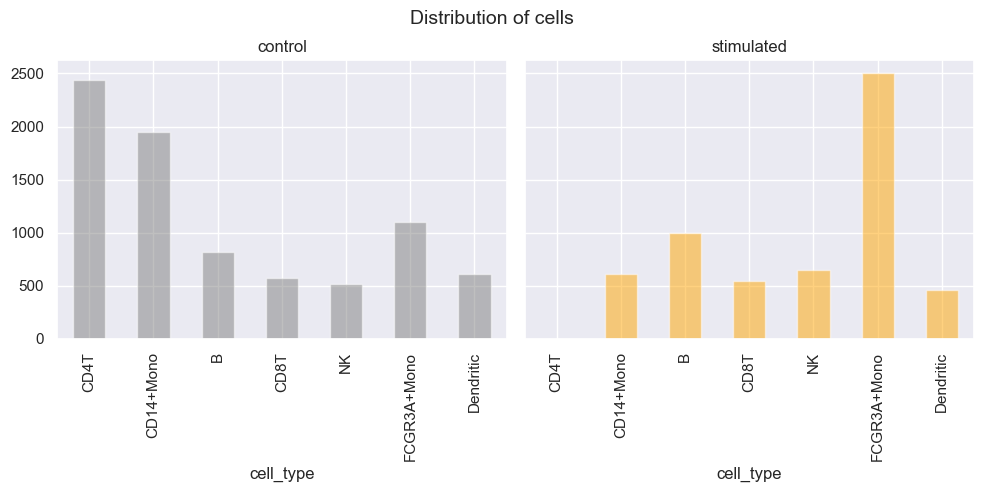

In [130]:
plot_cell_type_distribution(train_new)
plt.savefig(os.path.join("figures", "cell_distribution.jpeg"), dpi=150)

### Balancing by resampling

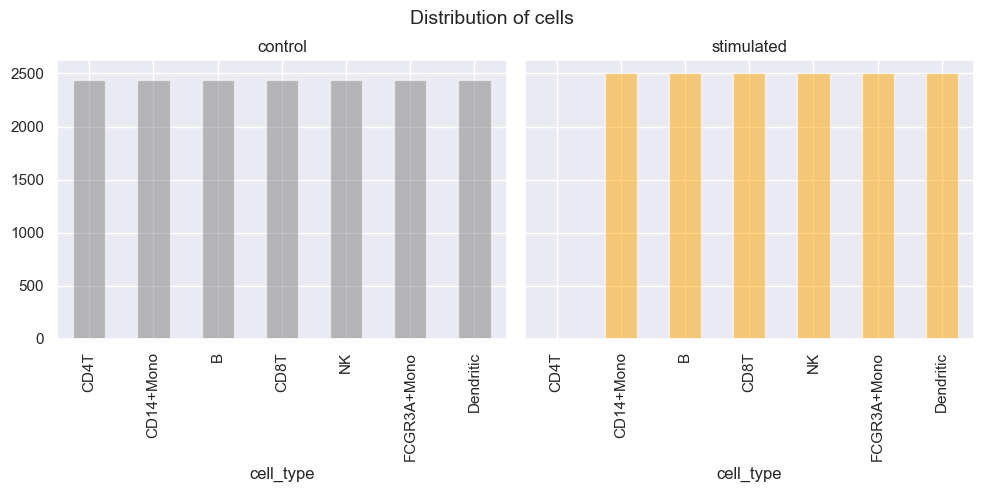

In [131]:
train_new_balanced = balance_classes_inside_segments(train_new, 
                                                     class_key=CELL_TYPE_KEY, 
                                                     segment_key=CONDITION_KEY, 
                                                     verbose=False)

plot_cell_type_distribution(train_new_balanced)
plt.savefig(os.path.join("figures", "cell_distribution_after_balancing.jpeg"), dpi=150)

## Show the effect of a class imbalance

The simple approach consists of:
1. Start with a balanced dataset, train model and evaluate it with $R^2$. 
2. Increase the imbalance rate and also compute $R^2$ score.
3. Keep increasing the imbalance rate step-by-step and evaluating the score each time.

If the imbalance has a significant effect, we should see a decrease of $R^2$ as we add more imbalance.

It is consistent with the idea from the [The differential impacts of dataset imbalance in single-cell data integration](https://www.biorxiv.org/content/10.1101/2022.10.06.511156v2) article:
```
To address this gap, we developed the Iniquitate pipeline for assessing the stability of single-cell RNA sequencing (scRNA-seq) integration results after perturbing the degree of imbalance between datasets
```

Weaknesses:
1. Currently our custom VAE model have much worse $R^2$ score compared to scGen. We should improve it.
2. As we add more instances to increase imbalance, we just give the model more data, which can imrove it's performance. 
3. Perhaps, we should have selected only specific cell types, not all dataset.

**@Pavlo's thoughts about the core of the problem of data imbalance**

1. It assigns a false importance weights for the classes.
Imbalance is a problem, because model learns to give some classes more importance than to the others. But we need all cell types to be equally important. For example, if we have $95\%$ of cells of type CD4T and only $10\%$ of type B, we will learn the patterns of a former, but we will give less importance to the latter. This can be fixed by adding resampled data. But the core reason remains: how can we assign a weights of importance to our observarions? How can we evaluate, which cells are more important to take into account, and which are less importtant? One simple idea to start: leave-one-out technique. We hold out one cell type and train a model on others. After that we compare, how the score is changed. If score decreases significantly, this cell type is extremely important, otherwise - it is less important.

2. Also, it may be an issue, that for some classes we simply don't have enough data to catch the pattern of treatment effect. 


In [158]:
cell_types = train_new.obs[CELL_TYPE_KEY].drop_duplicates().to_list()
cell_types

['NK', 'Dendritic', 'B', 'FCGR3A+Mono', 'CD14+Mono', 'CD8T', 'CD4T']

In [159]:
model_directory = os.path.join("models", "imbalance_test")
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [160]:
def get_sample_balance_proportion(adata, imbalance_cell_types, start=1000, step=100, i=0, verbose=False):
    np.random.seed(43)
    if verbose: print(f'Dataset size: {adata.shape[0]} cells')
    # leave the cells, that doesn't belong to the imbalanced class
    index_all = [
                 adata[~adata.obs[CELL_TYPE_KEY].isin(imbalance_cell_types)].obs.index.values
                ]
    for condition in [STIMULATED_KEY, CONTROL_KEY]:
        if verbose:        
            print('-'*20, '\n', condition)
        adata_temp = adata[adata.obs[CONDITION_KEY] == condition]
        for cell_type in imbalance_cell_types:
            if verbose: print(cell_type, end=' ')
            index = adata_temp[adata_temp.obs[CELL_TYPE_KEY] == cell_type].obs.index.values
            if verbose: print(len(index), end=' | ')
            np.random.shuffle(index)
            index_stay, index_hold_out = index[:start + i*step], index[start + i*step:]
            if verbose: print(len(index_stay), len(index_hold_out))
            index_all.append(index_stay)
    index_all = np.concatenate(index_all)
    adata_sample = adata[index_all]
    if verbose: print(f'\nDataset sample size: {adata_sample.shape[0]} cells')
    return adata_sample
    
n_steps = 15

# table to store results
df_results = pd.DataFrame(data=np.zeros((n_steps, 2)), index=np.arange(n_steps), columns=['r2', 'r2_diff_genes'])

start, step = 1000, 100
imbalance_cell_types = ['CD4T', 'CD14+Mono', 'FCGR3A+Mono']
print(f'VAE model configuration: \n\tN_INPUT = {N_INPUT}\n\tN_HIDDEN = {N_HIDDEN}\n\tN_LAYERS = {N_LAYERS}\n\tN_LATENT = {N_LATENT}\n\tBATCH_SIZE = {BATCH_SIZE}')
print(f'Starting with a threshold of {start} instances for each of the dominating cell types {imbalance_cell_types}')

for i in range(n_steps):
    print(f'{i}th step, threshold: {start + step*i} instances')
    adata_sample = get_sample_balance_proportion(train_new, 
                                                 imbalance_cell_types=imbalance_cell_types, 
                                                 start=start, step=step, i=i, verbose=False)

    params_filename = os.path.join("models", "imbalance_test", f"{i}_autoencoder.pt")
    create_and_train_vae_model(adata_sample, 
                               epochs=15, 
                               save_params_to_filename=params_filename)

    r2, r2_diff_genes = evaluate_r2(params_filename)
    df_results.loc[i, ["r2", "r2_diff_genes"]] = [r2, r2_diff_genes]

VAE model configuration: 
	N_INPUT = 6998
	N_HIDDEN = 100
	N_LAYERS = 3
	N_LATENT = 10
	BATCH_SIZE = 32
Starting with a threshold of 1000 instances for each of the dominating cell types ['CD4T', 'CD14+Mono', 'FCGR3A+Mono']
0th step, threshold: 1000 instances
1th step, threshold: 1100 instances
2th step, threshold: 1200 instances
3th step, threshold: 1300 instances
4th step, threshold: 1400 instances
5th step, threshold: 1500 instances
6th step, threshold: 1600 instances
7th step, threshold: 1700 instances
8th step, threshold: 1800 instances
9th step, threshold: 1900 instances
10th step, threshold: 2000 instances
11th step, threshold: 2100 instances
12th step, threshold: 2200 instances
13th step, threshold: 2300 instances
14th step, threshold: 2400 instances


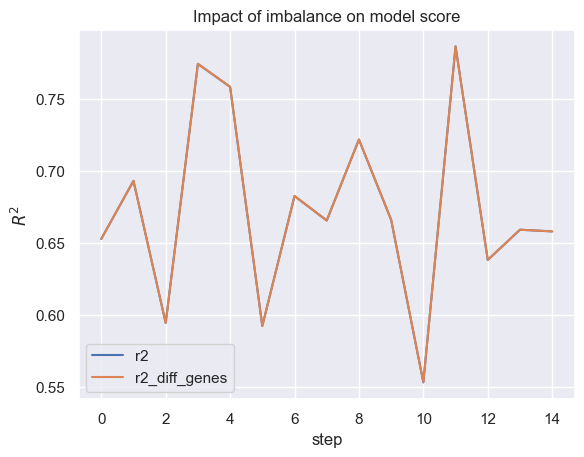

In [161]:
df_results.plot(y=['r2', 'r2_diff_genes'], kind='line');
plt.title('Impact of imbalance on model score')
plt.xlabel('step')
plt.ylabel('$R^2$');

In [144]:
### Downsampling strategy

In [145]:
def get_downsampling_proportion(adata, threshold=1000, i=0, verbose=False):
    np.random.seed(43)
    if verbose: print(f'Dataset size: {adata.shape[0]} cells')
    index_all = []
    for condition in [STIMULATED_KEY, CONTROL_KEY]:
        if verbose:
            print('-'*20, '\n', condition)
        adata_in_condition = adata[adata.obs[CONDITION_KEY] == condition]
        for cell_type in adata.obs[CELL_TYPE_KEY].cat.categories.values:
            if verbose: print(cell_type, end=' ')
            index = adata_in_condition[adata_in_condition.obs[CELL_TYPE_KEY] == cell_type].obs.index.values
            if verbose: print(len(index), end=' | ')
            index_stay, index_hold_out = index[:threshold], index[threshold:]
            if verbose: print(len(index_stay), len(index_hold_out))
            index_all.append(index_stay)
    if verbose:
        condition_size = int(len(index_all) / 2)
        index_all_temp = np.concatenate(index_all)
        print('-'*20, '\n', STIMULATED_KEY)
        for index_certain in index_all[:condition_size]:
            print(f"Partition: {len(index_certain)/len(index_all_temp)*2*100}%")
        print('-'*20, '\n', CONTROL_KEY)
        for index_certain in index_all[condition_size:]:
            print(f"Partition: {len(index_certain)/len(index_all_temp)*2*100}%")
    index_all = np.concatenate(index_all)
    adata_sample = adata[index_all]
    if verbose: print(f'\nDataset sample size: {adata_sample.shape[0]} cells')
    return adata_sample

In [146]:
model_directory = os.path.join("models", "downsampling_test")

if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [147]:
n_steps = 5

# table to store results
df_results = pd.DataFrame(data=np.zeros((n_steps, 2)), 
                          index=np.arange(n_steps), 
                          columns=['r2', 'r2_diff_genes'])

threshold, step = 1000, 100
print(f'VAE model configuration: \n\tN_INPUT = {N_INPUT}\n\tN_HIDDEN = {N_HIDDEN}\n\tN_LAYERS = {N_LAYERS}\n\tN_LATENT = {N_LATENT}\n\tBATCH_SIZE = {BATCH_SIZE}')
print(f'Starting downsampling with a threshold of {threshold} instances for each of the cell types')

for i in range(n_steps + 1):
    print(f'{i}th step, threshold: {threshold} instances')
    adata_sample = get_downsampling_proportion(train_new, 
                                               threshold=threshold, 
                                               i=i,
                                               verbose=True)

    params_filename = os.path.join("models", "downsampling_test", f"{i}_autoencoder.pt")
    create_and_train_vae_model(adata_sample,
                               epochs=n_steps, 
                               save_params_to_filename=params_filename)

    r2, r2_diff_genes = evaluate_r2(params_filename)
    df_results.loc[i, ["r2", "r2_diff_genes"]] = [r2, r2_diff_genes]
    
    # Step into lower sample threshold
    threshold -= step

VAE model configuration: 
	N_INPUT = 6998
	N_HIDDEN = 100
	N_LAYERS = 3
	N_LATENT = 10
	BATCH_SIZE = 32
Starting downsampling with a threshold of 1000 instances for each of the cell types
0th step, threshold: 1000 instances
Dataset size: 13766 cells
-------------------- 
 stimulated
CD4T 0 | 0 0
CD14+Mono 615 | 615 0
B 993 | 993 0
CD8T 541 | 541 0
NK 646 | 646 0
FCGR3A+Mono 2501 | 1000 1501
Dendritic 463 | 463 0
-------------------- 
 control
CD4T 2437 | 1000 1437
CD14+Mono 1946 | 1000 946
B 818 | 818 0
CD8T 574 | 574 0
NK 517 | 517 0
FCGR3A+Mono 1100 | 1000 100
Dendritic 615 | 615 0
-------------------- 
 stimulated
Partition: 0.0%
Partition: 12.574115722756082%
Partition: 20.302596606011043%
Partition: 11.061132692700879%
Partition: 13.20793293804948%
Partition: 20.445716622367613%
Partition: 9.466366796156207%
-------------------- 
 control
Partition: 20.445716622367613%
Partition: 20.445716622367613%
Partition: 16.72459619709671%
Partition: 11.735841341239011%
Partition: 10.5704354

Text(0, 0.5, '$R^2$')

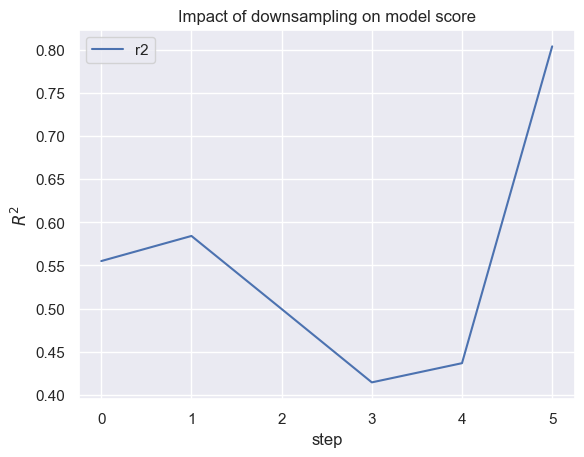

In [148]:
df_results.plot(y=['r2'], kind='line')
plt.title('Impact of downsampling on model score')
plt.xlabel('step')
plt.ylabel('$R^2$')

In [153]:
import math

def get_downsampling_minimum(adata, exclude_controled_cell_type=None, verbose=False):
    np.random.seed(43)
    if verbose: print(f'Dataset size: {adata.shape[0]} cells')
    # Find minimum threshold for downsampling among all cell type categories
    threshold, min_cell_type = (+math.inf, None)
    for condition in [STIMULATED_KEY, CONTROL_KEY]:
        adata_in_condition = adata[adata.obs[CONDITION_KEY] == condition]
        for cell_type in adata.obs[CELL_TYPE_KEY].cat.categories.values:
            if condition == CONTROL_KEY or cell_type != exclude_controled_cell_type:
                index_size = len(adata_in_condition[adata_in_condition.obs[CELL_TYPE_KEY] == cell_type].obs.index.values)
                if index_size != 0 and threshold > index_size:
                    threshold = index_size
                    min_cell_type = cell_type
    if verbose:
        print(f"Minimum cell type {min_cell_type} with size: {threshold}")
    # Downsampling by minimum threshold
    index_all = []
    for condition in [STIMULATED_KEY, CONTROL_KEY]:
        if verbose:
            print('-'*20, '\n', condition)
        adata_in_condition = adata[adata.obs[CONDITION_KEY] == condition]
        for cell_type in adata.obs[CELL_TYPE_KEY].cat.categories.values:
            if condition == CONTROL_KEY or cell_type != exclude_controled_cell_type:
                if verbose: print(cell_type, end=' ')
                index = adata_in_condition[adata_in_condition.obs[CELL_TYPE_KEY] == cell_type].obs.index.values
                if verbose: print(len(index), end=' | ')
                index_stay, index_hold_out = index[:threshold], index[threshold:]
                if verbose: print(len(index_stay), len(index_hold_out))
                index_all.append(index_stay)
            else:
                if verbose: print(f"{cell_type} 0 | 0 0")
    if verbose:
        condition_size = int(len(index_all) / 2)
        index_all_temp = np.concatenate(index_all)
        print('-'*20, '\n', STIMULATED_KEY)
        for index_certain in index_all[:condition_size]:
            print(f"Partition: {len(index_certain)/len(index_all_temp)*2*100}%")
        print('-'*20, '\n', CONTROL_KEY)
        for index_certain in index_all[condition_size:]:
            print(f"Partition: {len(index_certain)/len(index_all_temp)*2*100}%")
    index_all = np.concatenate(index_all)
    adata_sample = adata[index_all]
    if verbose: print(f'\nDataset sample size: {adata_sample.shape[0]} cells')
    return adata_sample

In [154]:
model_directory = os.path.join("models", "downsampling_minimum_test")

if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [155]:
adata_sample = get_downsampling_minimum(train_new,
                                        verbose=True)

params_filename = os.path.join("models", "downsampling_minimum_test", f"autoencoder.pt")
create_and_train_vae_model(adata_sample,
                           epochs=n_steps,
                           save_params_to_filename=params_filename)

r2_downsampled, r2_diff_genes_downsampled = evaluate_r2(params_filename)
print(f"R*2 downsampled: {r2_downsampled}")
print(f"R*2 diff downsampled: {r2_diff_genes_downsampled}")

Dataset size: 13766 cells
Minimum cell type Dendritic with size: 463
-------------------- 
 stimulated
CD4T 0 | 0 0
CD14+Mono 615 | 463 152
B 993 | 463 530
CD8T 541 | 463 78
NK 646 | 463 183
FCGR3A+Mono 2501 | 463 2038
Dendritic 463 | 463 0
-------------------- 
 control
CD4T 2437 | 463 1974
CD14+Mono 1946 | 463 1483
B 818 | 463 355
CD8T 574 | 463 111
NK 517 | 463 54
FCGR3A+Mono 1100 | 463 637
Dendritic 615 | 463 152
-------------------- 
 stimulated
Partition: 0.0%
Partition: 15.384615384615385%
Partition: 15.384615384615385%
Partition: 15.384615384615385%
Partition: 15.384615384615385%
Partition: 15.384615384615385%
Partition: 15.384615384615385%
-------------------- 
 control
Partition: 15.384615384615385%
Partition: 15.384615384615385%
Partition: 15.384615384615385%
Partition: 15.384615384615385%
Partition: 15.384615384615385%
Partition: 15.384615384615385%
Partition: 15.384615384615385%

Dataset sample size: 6019 cells
R*2 downsampled: 0.37769096902562027
R*2 diff downsampled: 0.3

In [156]:
### Leave one cell type out

In [157]:
exclude_cell_types = ["CD14+Mono", "B", "CD8T", "NK", "FCGR3A+Mono", "Dendritic"]

for exclude_cell_type in exclude_cell_types:
    adata_sample = get_downsampling_minimum(train_new,
                                            exclude_controled_cell_type=exclude_cell_type,
                                            verbose=True)

    params_filename = os.path.join("models", "downsampling_minimum_test", f"{exclude_cell_type}_autoencoder.pt")
    create_and_train_vae_model(adata_sample,
                               epochs=n_steps,
                               save_params_to_filename=params_filename)

    r2_downsampled, r2_diff_genes_downsampled = evaluate_r2(params_filename)
    print(f"R*2 with {exclude_cell_type} excluded: {r2_downsampled}")
    print(f"R*2 diff downsampled with {exclude_cell_type} excluded: {r2_diff_genes_downsampled}")

Dataset size: 13766 cells
Minimum cell type Dendritic with size: 463
-------------------- 
 stimulated
CD4T 0 | 0 0
Skipping cell type CD14+Mono
B 993 | 463 530
CD8T 541 | 463 78
NK 646 | 463 183
FCGR3A+Mono 2501 | 463 2038
Dendritic 463 | 463 0
-------------------- 
 control
CD4T 2437 | 463 1974
CD14+Mono 1946 | 463 1483
B 818 | 463 355
CD8T 574 | 463 111
NK 517 | 463 54
FCGR3A+Mono 1100 | 463 637
Dendritic 615 | 463 152
-------------------- 
 stimulated
Partition: 0.0%
Partition: 16.666666666666664%
Partition: 16.666666666666664%
Partition: 16.666666666666664%
Partition: 16.666666666666664%
Partition: 16.666666666666664%
-------------------- 
 control
Partition: 16.666666666666664%
Partition: 16.666666666666664%
Partition: 16.666666666666664%
Partition: 16.666666666666664%
Partition: 16.666666666666664%
Partition: 16.666666666666664%
Partition: 16.666666666666664%

Dataset sample size: 5556 cells
R*2 with CD14+Mono excluded: 0.38927952390490417
R*2 diff downsampled with CD14+Mono exc